# Intelligent system for monitoring indoor air quality and fight against COVID-19.<br>
**Extract Data Analysis**.<br>
Notebook developed in Python with the aim to make forecasting time-series in order to predict how CO2 measure is going to fluctuate in a near future.<br>
This forecsting allows a proactive action to alert the users near the device and encourage them to ventilate the indoor area where the device is located.<br>
Author: Felix Angel Martinez Muela

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png"><br>
**Attribution-NonCommercial-ShareAlike**<br>
**CC BY-NC-SA**

This license lets others remix, adapt, and build upon your work non-commercially, as long as they credit you and license their new creations under the identical terms.<br>
[View License Deed](https://creativecommons.org/licenses/by-nc-sa/4.0) | [View Legal Code](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode)

Installation of necessary libraries.

In [39]:
%%capture
!pip install pandas
!pip install matplotlib
!pip install azure-cosmos
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install tsmoothie

In [40]:
import os
import time
import datetime
import json
import matplotlib.pyplot as plt
from azure.cosmos import CosmosClient
import pandas as pd
from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
from tsmoothie.smoother import LowessSmoother

Starting measuring execution time.

In [41]:
start_time = time.time()

Environment variables.

In [42]:
os.environ['ACCOUNT_URI'] = "https://airq-cosmos.documents.azure.com:443/"
os.environ['ACCOUNT_KEY'] = "s8bh08THd91Yt6nNbZDN99r6fHH212UCr8l4cuP7v7ySUj3Nps5DDUgIgmIix4QnP481e99UK6NbaQ99AfO9dg=="

CosmosDB client.

In [43]:
url = os.environ['ACCOUNT_URI']
key = os.environ['ACCOUNT_KEY']

client = CosmosClient(url, credential=key)
database_name = 'airq-db'
database = client.get_database_client(database_name)
container_name = 'telemetry'
container = database.get_container_client(container_name)

NoSQL Data base (CosmosDB) properties.

In [44]:
properties = database.read()
print(json.dumps(properties))

{"id": "airq-db", "_rid": "vohrAA==", "_self": "dbs/vohrAA==/", "_etag": "\"0000689f-0000-0d00-0000-60b5ee1b0000\"", "_colls": "colls/", "_users": "users/", "_ts": 1622535707}


Unix Timestamp a week before.

In [45]:
last_x_days=7

In [46]:
yesterday = datetime.date.today() - datetime.timedelta(last_x_days)
unix_time= yesterday.strftime("%s") #Second as a decimal number [00,61] (or Unix Timestamp)
print(unix_time)

1623801600


Query only  data of the following device.

In [47]:
deviceid='"24:A1:60:58:09:94"'

Database query.

In [48]:
query= 'SELECT * FROM c WHERE (c.deviceid = {deviceid}) AND (c.time>{unix_time}) ORDER BY c._ts ASC'.format(deviceid=deviceid, unix_time=unix_time)

Query to the database and document concatenation to a list.

In [49]:
dflist = []
for item in container.query_items(
        query=query,
        enable_cross_partition_query=True):
    print(json.dumps(item, indent=True))
    dflist.append(dict(item))

Streaming output truncated to the last 5000 lines.
{
 "deviceid": "24:A1:60:58:09:94",
 "time": 1624455734,
 "temperature": 24.58,
 "humidity": 43.33,
 "pressure": 935.13,
 "altitude": 671.66,
 "co2": 604,
 "rawco2": 37228,
 "pm25": 4.5,
 "pm10": 11.5,
 "tvoc": 20,
 "eco2": 1759,
 "rawh2": 13721,
 "rawethanol": 19983,
 "lux": 13.13,
 "whitelux": 52.53,
 "rawals": 114.0,
 "id": "833909cf-c054-4a0e-b92f-8da34eb5e7fb",
 "_rid": "vohrAJUZE5GeYgAAAAAAAA==",
 "_self": "dbs/vohrAA==/colls/vohrAJUZE5E=/docs/vohrAJUZE5GeYgAAAAAAAA==/",
 "_etag": "\"00007164-0000-0d00-0000-60d33a370000\"",
 "_attachments": "attachments/",
 "_ts": 1624455735
}
{
 "deviceid": "24:A1:60:58:09:94",
 "time": 1624455806,
 "temperature": 24.62,
 "humidity": 43.23,
 "pressure": 935.14,
 "altitude": 671.59,
 "co2": 602,
 "rawco2": 37231,
 "pm25": 4.7,
 "pm10": 14.3,
 "tvoc": 14,
 "eco2": 1746,
 "rawh2": 13738,
 "rawethanol": 20001,
 "lux": 13.36,
 "whitelux": 52.99,
 "rawals": 116.0,
 "id": "f1c6cccf-fe77-4e4d-b9b3-5c31e

Explanation of the data received by the CosmosDB database.<br>
Data: <br>
0.   **deviceid**: MAC direction of the device's wifi.
1.   **time**: time at which the measured values were collected with UTC time. Value generated per IoT device.
2.   **temperature**: temperature in Celsius degrees. Value generated by BME280 sensor.
3.   **humidity**: relative humidity percentage %. Value generated by BME280 sensor.
4.   **pressure**: atmospheric pressure in hPa. Value generated by BME280 sensor.
5.   **altitude**: altitude at which the device is located as a function of its atmospheric pressure. Indicative value and that takes as reference the atmospheric pressure at sea level: 1013.25 hPa. Value generated by BME280 sensor.
6.   **co2**: CO2 particles measured in ppm. Value generated by MHZ19 sensor.
7.   **rawco2**: value captured by the sensor regardless of calibration. Value generated by MHZ19 sensor.
8.   **pm25**: 2.5 micron airborne particles measured in ppm. Value generated by SDS011 sensor.
9.   **pm10** 10 micron airborne particles measured in ppm. Value generated by SDS011 sensor.
10.   **tvoc**: Volatile Organic Compound particles in suspension in the air, measured in ppb. Value generated by sensor.
11.   **eco2**: CO2 particles measured in ppm. Value generated by SGP30 sensor.
12.   **rawh2**: dihydrogen particles in the air. Value needed to measure eCO2 and TVOC. Value generated by SGP30 sensor.
13.   **rawethanol**: ethanol particles in the air. Value required to measure eCO2 and TVOC. Value generated by SGP30 sensor.
14.   **lux**: value indicating the brightness found in the environment, measured in lx, equivalent to 1 lm/m² Value generated by VEML7700 sensor.
15.   **whitelux**: value indicating the brightness of the white color found in the environment, measured in lx, equivalent to 1 lm/m². Value generated by VEML7700 sensor.
16.   **rawals**: raw value to obtain lux and whitelux. Value generated by VEML7700 sensor.
17.   **id**: indicates the document identifier. Value generated by the database.
18.   **_rid**: indicates the document identifier. Value generated by the database.
19.   **_self**: indicates the document URI. Value generated by the database.
20.   **_etag**: value necessary to manage the simultaneity of the documents. Value generated by the database.
21.   **_attachments**: indicates attachments associated with the document. Value generated by the database.
22.   **_ts**: indicates when the document was last modified. Value generated by the database.

Creation of the dataframe from the query.

In [50]:
df = pd.DataFrame(dflist)

We list the number of devices that have sent data.

In [51]:
devices = df.deviceid.unique()
print(devices)

['24:A1:60:58:09:94']


Select from the data frame only the rows that belong to the device you are interested in.

In [52]:
df = df.loc[df['deviceid'] == '24:A1:60:58:09:94']

We eliminate from the DF the data that do not add value <br>
The values that for the development of the model do not contribute value are the following: deviceid, altitude, rawco2, rawh2, rawethanol, rawals, id, _rid, _self, _etag, attachements, _ts.

In [53]:
df = df.drop(['deviceid','altitude','rawco2','rawh2','rawethanol','rawals','id','_rid','_self','_etag','_attachments','_ts'], 1)

In [54]:
df = df.rename(columns={'time': 'Date'}) # Adjustment of column names
df['Date']= pd.to_datetime(df['Date'], unit='s') # Conversion to date type
df = df.sort_values('Date')  # Sort by date
df['Date'] = df['Date'].dt.floor('min')  # Approaching seconds to minutes
df=df.drop_duplicates(subset='Date', keep='first') # Deletion of data with the same index
df.set_index('Date', inplace=True, drop=False) # Date column as index of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9262 entries, 2021-06-16 00:00:00 to 2021-06-23 17:41:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         9262 non-null   datetime64[ns]
 1   temperature  9262 non-null   float64       
 2   humidity     9262 non-null   float64       
 3   pressure     9262 non-null   float64       
 4   co2          9262 non-null   int64         
 5   pm25         9262 non-null   float64       
 6   pm10         9262 non-null   float64       
 7   tvoc         9262 non-null   int64         
 8   eco2         9262 non-null   int64         
 9   lux          9262 non-null   float64       
 10  whitelux     9262 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 868.3 KB


---
**NaN checking & filling**


We create a dataframe that contains a correct time series.
We join our df to the dataframe that has the valid time series.

In [55]:
# generate second dataframe with needed index
timerange = pd.date_range(start=df.first_valid_index(), end=df.last_valid_index(), freq='1min')
df2 = pd.DataFrame(index=timerange)

# join the original dataframe with the new one
newdf = df.join(df2, how='outer')

Find Nan Rows

In [56]:
is_NaN = newdf.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = newdf[row_has_NaN]

print(rows_with_NaN)

                    Date  temperature  humidity  ...  eco2  lux  whitelux
2021-06-16 00:01:00  NaT          NaN       NaN  ...   NaN  NaN       NaN
2021-06-16 00:07:00  NaT          NaN       NaN  ...   NaN  NaN       NaN
2021-06-16 00:13:00  NaT          NaN       NaN  ...   NaN  NaN       NaN
2021-06-16 00:19:00  NaT          NaN       NaN  ...   NaN  NaN       NaN
2021-06-16 00:25:00  NaT          NaN       NaN  ...   NaN  NaN       NaN
...                  ...          ...       ...  ...   ...  ...       ...
2021-06-23 17:11:00  NaT          NaN       NaN  ...   NaN  NaN       NaN
2021-06-23 17:18:00  NaT          NaN       NaN  ...   NaN  NaN       NaN
2021-06-23 17:24:00  NaT          NaN       NaN  ...   NaN  NaN       NaN
2021-06-23 17:30:00  NaT          NaN       NaN  ...   NaN  NaN       NaN
2021-06-23 17:36:00  NaT          NaN       NaN  ...   NaN  NaN       NaN

[1880 rows x 11 columns]


Interpolate the missing values in a linear method between non missed values.

In [57]:
newdf=newdf.interpolate(method ='linear', limit_direction ='forward') 

We adjust the NaT to have the same value as the index.

In [58]:
newdf['Date'] = newdf.index

In [59]:
newdf

Date  temperature  ...   lux  whitelux
2021-06-16 00:00:00 2021-06-16 00:00:00        27.45  ...  0.00      0.00
2021-06-16 00:01:00 2021-06-16 00:01:00        27.46  ...  0.00      0.00
2021-06-16 00:02:00 2021-06-16 00:02:00        27.47  ...  0.00      0.00
2021-06-16 00:03:00 2021-06-16 00:03:00        27.47  ...  0.00      0.00
2021-06-16 00:04:00 2021-06-16 00:04:00        27.50  ...  0.00      0.00
...                                 ...          ...  ...   ...       ...
2021-06-23 17:37:00 2021-06-23 17:37:00        24.98  ...  5.30     14.75
2021-06-23 17:38:00 2021-06-23 17:38:00        24.94  ...  4.38     11.52
2021-06-23 17:39:00 2021-06-23 17:39:00        24.96  ...  6.22     17.51
2021-06-23 17:40:00 2021-06-23 17:40:00        25.01  ...  4.15     10.94
2021-06-23 17:41:00 2021-06-23 17:41:00        24.97  ...  3.92     10.25

[11142 rows x 11 columns]

---


**Exploratory Data Analysis**

In [60]:
newdf.describe()

temperature      humidity  ...           lux      whitelux
count  11142.000000  11142.000000  ...  11142.000000  11142.000000
mean      25.084821     40.489300  ...      6.260298     24.008075
std        1.780753      2.910069  ...      9.084034     35.574071
min       19.820000     31.600000  ...      0.000000      0.000000
25%       24.580000     38.720000  ...      0.000000      0.000000
50%       25.330000     40.415000  ...      2.530000     11.345000
75%       26.010000     42.647500  ...      9.790000     37.366250
max       28.520000     51.460000  ...    124.880000    342.600000

[8 rows x 10 columns]

Exploratory Data Analysis<br>
https://github.com/pandas-profiling/pandas-profiling

In [61]:
profile = ProfileReport(newdf, title="AIRQ Profiling Report", explorative=True)

In [62]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
profile.to_file("airq_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Graphical representation of the values present in the CosmosDB database.

mkdir: cannot create directory ‘diagrams/’: File exists


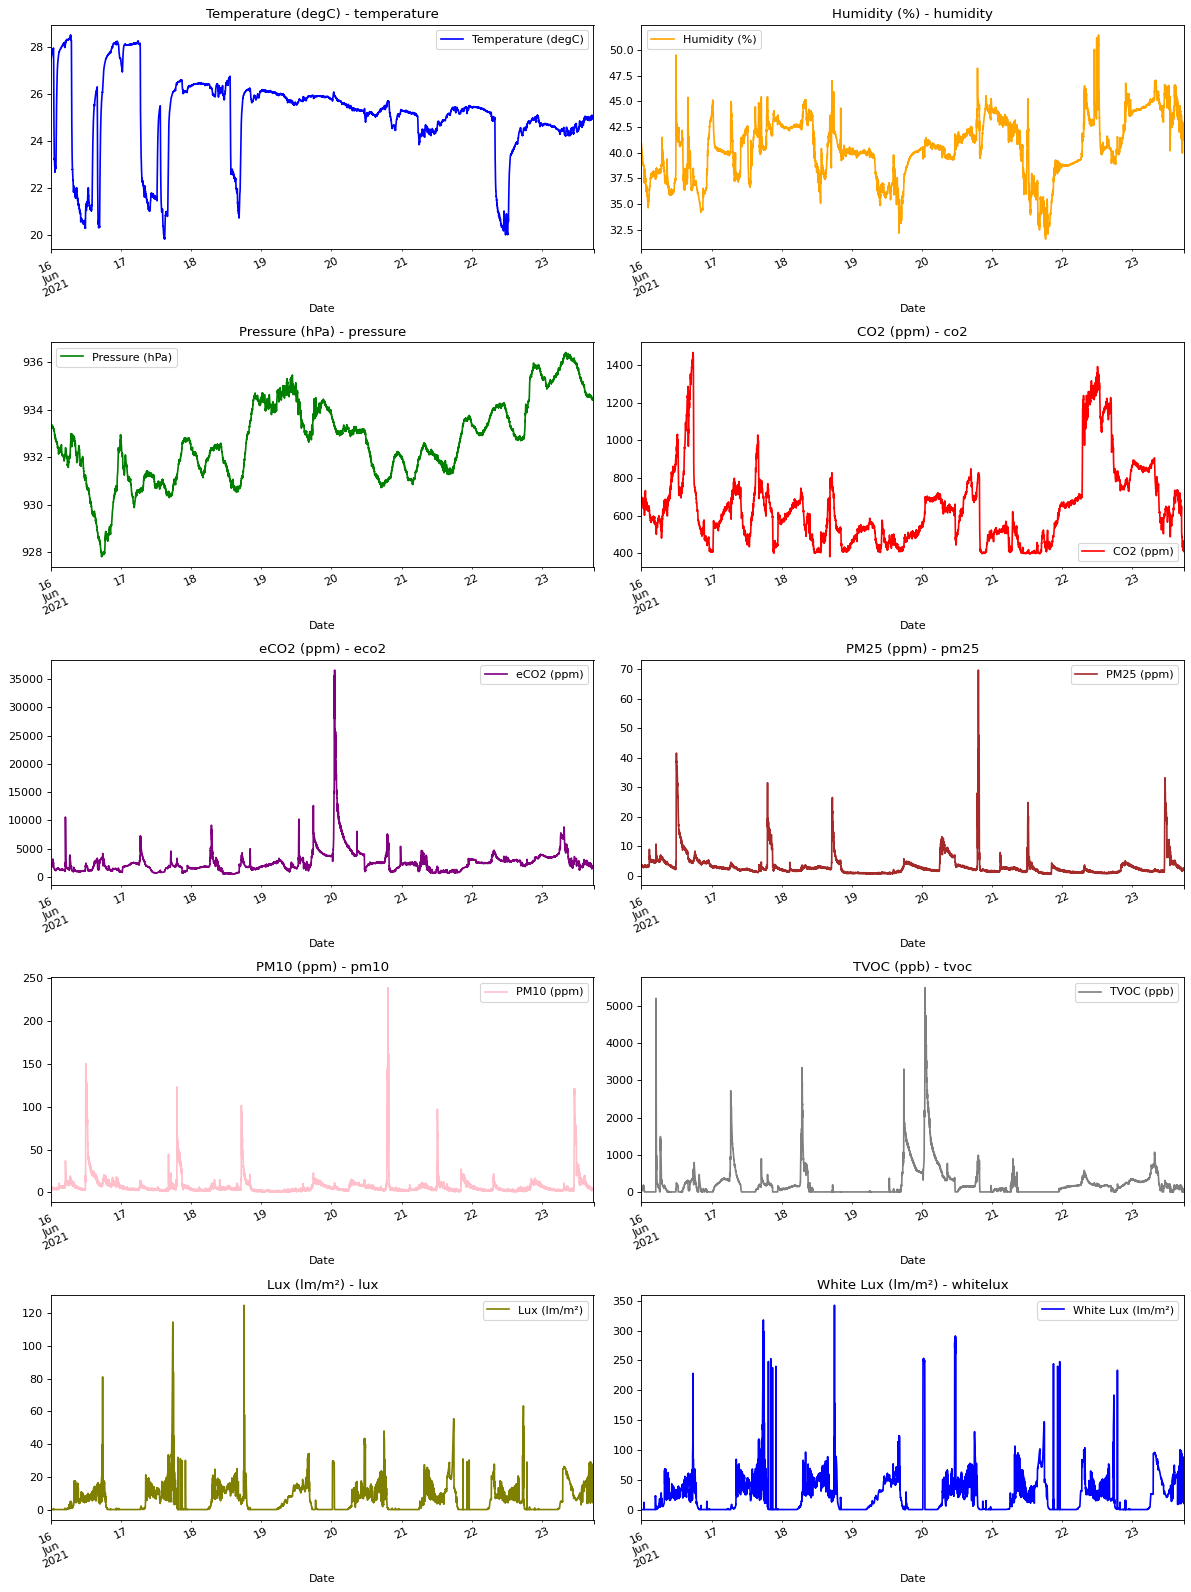

In [64]:
!mkdir diagrams/
titles = [
    "Temperature (degC)",
    "Humidity (%)",
    "Pressure (hPa)",
    "CO2 (ppm)",
    "eCO2 (ppm)",
    "PM25 (ppm)",
    "PM10 (ppm)",
    "TVOC (ppb)",
    "Lux (lm/m²)",
    "White Lux (lm/m²)",
]

feature_keys = [
    "temperature",
    "humidity",
    "pressure",
    "co2",
    "eco2",
    "pm25",
    "pm10",
    "tvoc",
    "lux",
    "whitelux",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
]

date_time_key = "Date"

def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=5, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])        
    plt.tight_layout()
    plt.savefig('diagrams/diagram')

show_raw_visualization(newdf)

Correlation Heat Map

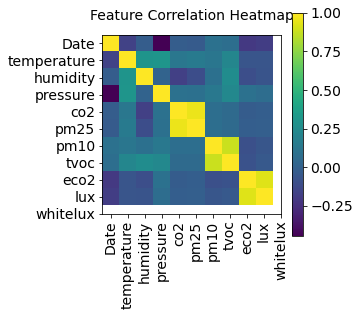

In [65]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()
show_heatmap(newdf)



---


**Seasonality**

Models: additive | multiplicable

In [66]:
result=seasonal_decompose(newdf['co2'],  model='additive', freq=24*60)

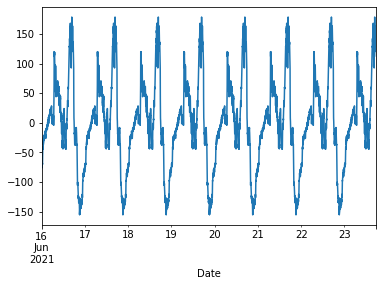

In [67]:
result.seasonal.plot()

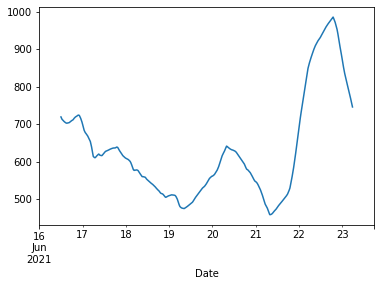

In [68]:
result.trend.plot()

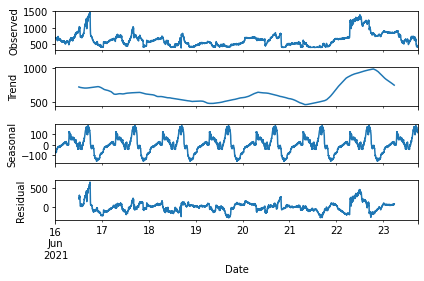

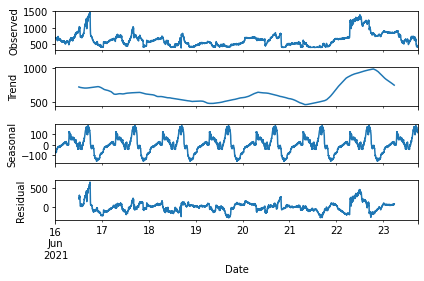

In [69]:
result.plot()



---


**Outliers & Anomalies Detection**<br>
https://pypi.org/project/tsmoothie/

In [70]:
data = newdf['co2'].values.reshape(1, -1)

In [71]:
# operate smoothing
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smoother.smooth(data)

# generate intervals
low, up = smoother.get_intervals('prediction_interval')

In [72]:
points = smoother.data[0]
up_points = up[0]
low_points = low[0]

Outliers plot

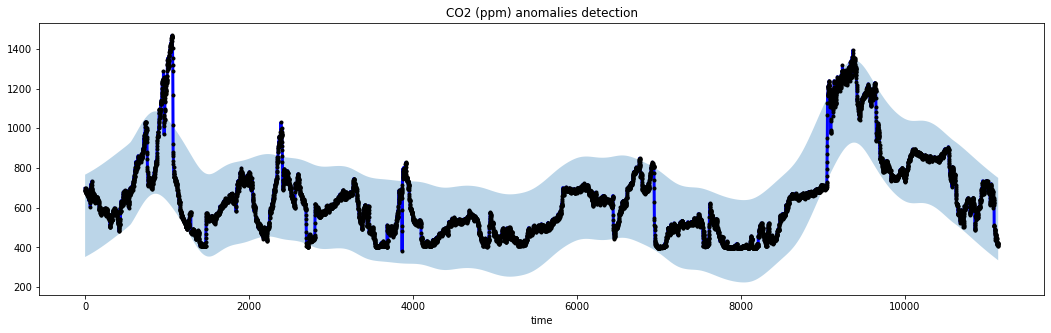

In [73]:
plt.figure(figsize=(18,5))
plt.plot(points, linewidth=3, color='blue')
plt.plot(points, '.k')
plt.title(f"CO2 (ppm) anomalies detection"); plt.xlabel('time')

plt.fill_between(range(len(points)), low_points, up_points, alpha=0.3)

Outliers detected:

In [74]:
time_df=newdf.index.tolist()

In [75]:
outliers=[]
for i in range(len(points)-1, 0, -1):
    current_point = points[i]
    current_up = up_points[i]
    current_low = low_points[i]
    current_time = time_df[i]
    if current_point > current_up or current_point < current_low:
        print(f'found an outlier value: {current_point} at {current_time}')
        current_outlier = dict([('outlier',current_point),('time',current_time)])
        outliers.append(current_outlier)

found an outlier value: 1228.0 at 2021-06-22 16:36:00
found an outlier value: 1227.0 at 2021-06-22 16:35:00
found an outlier value: 1228.0 at 2021-06-22 16:34:00
found an outlier value: 1347.5 at 2021-06-22 12:29:00
found an outlier value: 1353.0 at 2021-06-22 12:28:00
found an outlier value: 1350.0 at 2021-06-22 12:12:00
found an outlier value: 1351.0 at 2021-06-22 12:11:00
found an outlier value: 1356.0 at 2021-06-22 12:10:00
found an outlier value: 1361.0 at 2021-06-22 12:09:00
found an outlier value: 1380.0 at 2021-06-22 12:08:00
found an outlier value: 1364.0 at 2021-06-22 12:07:00
found an outlier value: 1393.0 at 2021-06-22 12:06:00
found an outlier value: 1361.0 at 2021-06-22 12:05:00
found an outlier value: 1343.5 at 2021-06-22 12:04:00
found an outlier value: 1348.0 at 2021-06-22 12:02:00
found an outlier value: 1361.0 at 2021-06-22 11:59:00
found an outlier value: 1339.0 at 2021-06-22 11:41:00
found an outlier value: 1317.0 at 2021-06-22 10:00:00
found an outlier value: 1260

Execution time finished.

In [76]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 77.84748125076294 seconds ---
